# Outlier Detection in Elastic Stack

Our outlier detection system provides scalable and efficient outlier detection. But all the pipelining, progress reporting, memory constraints, etc. can make it difficult to get down to the core of what it is doing. 

This notebook contains the algorithms we use in our outlier ensemble, written from scratch in a clear (though poor performing) manner. 

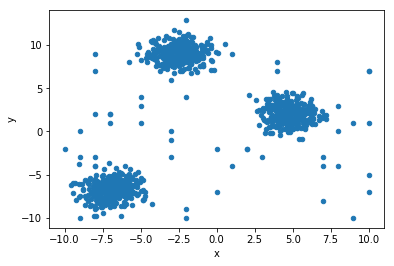

In [1]:
%matplotlib inline
# Generate some fake data clusters
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import random
import numpy as np

r_seed = 42

# Generate three 2D clusters totalling 1000 points 
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=r_seed)
random.seed(r_seed)
random_pts = []

# Generate random noise points that could be or could not be close to the clustered neighborhoods
for i in range(50):
    random_pts.append([random.randint(-10, 10), random.randint(-10, 10)])

X = np.append(X, random_pts, axis=0)

df = DataFrame(dict(x=X[:,0], y=X[:,1]))
df.plot(kind='scatter', x='x', y='y')
pyplot.show()

# The Algorithms

In our solution we utilize an ensemble of 4 separate algorithms. Each are based on either a density metric (how close together are my neighbors) or a distance metric (how far away are my neighbors). 

The four are
* Local Outlier factor (LoF)
    * This is a density metric that determines how dense a points local neighborhood is. The neighborhood is determined via the K nearest neighbors
* Local Distance-based outlier factor (LDoF)
    * This is a density + distance algorithm that is similar to LoF, but instead of worrying about neighborhood density, it looks at how far a point is from the perceived center of the neighborhood.
* K'th Nearest Neighbors Distance (KNN)
    * A distance metric that looks at how far away a point is from its Kth nearest neighbor
* K Nearest Neghbors Total Distance (TNN)
    * A distance metric that is the averaged distance to the K nearest neighbors

# Kth Nearest Neighbor Distance (KNN)

This is a very intuitive measure. How far away are you from your K'th neighbor? The farther away, the more likely you are to be an outlier from the set.

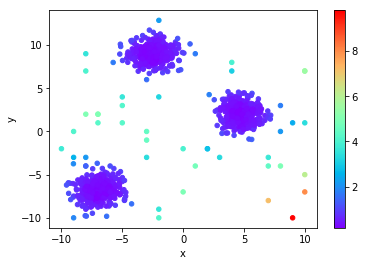

In [2]:
from matplotlib.colors import Normalize

k = 10

def k_nearest_neighbors(pt, pts):
    # Computes the Euclidean distance from pt to every point in pts
    distance_to_every_point = np.linalg.norm(pt - pts, axis=1)
    
    # Gets the sorted indices given the distances that we just found
    sorted_indices = np.argsort(distance_to_every_point)

    # Get the sorted points
    sorted_pts = pts[sorted_indices]
    
    # remove the first one as it is the same point as pt (because the distance is 0)
    # If there are duplicate points, this is OK, as long as just remove one duplicate
    # that could count as removing pt from the set pts
    sorted_pts = sorted_pts[1:]
    
    # Get me the first K of the sorted pts array
    return sorted_pts[:k] 

KNN_table = []

# Gather the KNN for every point and store them in order in a list
# There are more performant data structures and ways to do this, this is just simple
# Storing this information in a table as we will need it for the other algorithms
for i in range(X.shape[0]):
    KNN_table.append(k_nearest_neighbors(X[i], X))


# Gather the kth nearest neighbor distance
knn_distance = []
for i in range(X.shape[0]):
    knn_distance.append(np.linalg.norm(X[i] - KNN_table[i][k-1]))

# Print out our points colored by how far they are from their k'th nearest neighbor
norm = Normalize(vmin=min(knn_distance), vmax=max(knn_distance))
cmap = pyplot.cm.rainbow
df.plot(kind='scatter', x='x', y='y', color=cmap(norm(knn_distance)))
sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pyplot.colorbar(sm)
pyplot.show()


# Average distance to K Nearest Neighbors (TNN)

Very similar to K'th nearest neighbor distance, but instead of just worrying about the furthest distance, we average out all the distances to the K nearest neighbors

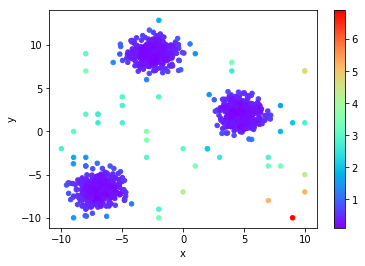

In [4]:
# Gather the kth nearest neighbor distance
tnn_distance = []
for i in range(X.shape[0]):
    k_distances = np.linalg.norm(X[i] - np.array(KNN_table[i]), axis=1)
    tnn_distance.append(np.mean(k_distances))

# Print out our points colored by average KNN distance
norm = Normalize(vmin=min(tnn_distance), vmax=max(tnn_distance))
cmap = pyplot.cm.rainbow
df.plot(kind='scatter', x='x', y='y', color=cmap(norm(tnn_distance)))
sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pyplot.colorbar(sm)
pyplot.show()


# Local Distance-based Outlier Factor (LDoF)

This algorithm is slightly more complicated, though not by much. 

The paper explaining it in depth is [here](https://arxiv.org/pdf/0903.3257.pdf).

Here is the simplified version.

We have already calculated one part of this algorith, our TNN (the average distance to the K nearest neighbors). Lets call keep this value as TNN(x), for some point x.

The other part is what the paper calls the "KNN inner distance". This is just the average of all the distances between all the points in the set of K nearest neighbors.

So, the Ldof(x) = TNN(x)/KNN_Inner_distance(KNN(x))

This combination makes this method a density and a distance measurement. The idea is that point with a LDoF score >> 1.0 is well outside of the cloud of K nearest neighbors. Any point with an LDoF score less than or "near" 1.0 could be considered "surrounded" via the cloud of neighbors. 

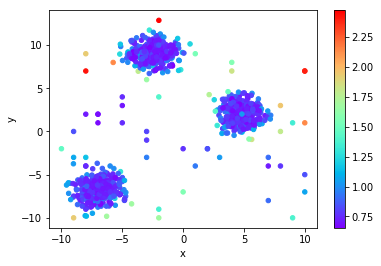

In [5]:

# Gather the inner distance for pts
def knn_inner_distance(pts):
    summation = 0
    for i in range(len(pts)):
        pt = pts[i]
        for j in range(len(pts)):
            summation = summation + np.linalg.norm(pt - pts[j])
    return summation / (k * (k - 1))

ldofs = []

for i in range(X.shape[0]):
    knn_i_d = knn_inner_distance(KNN_table[i])
    ldofs.append(tnn_distance[i]/knn_i_d)

# Print out our points colored by LDoF 
norm = Normalize(vmin=min(ldofs), vmax=max(ldofs))
cmap = pyplot.cm.rainbow
df.plot(kind='scatter', x='x', y='y', color=cmap(norm(ldofs)))
sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pyplot.colorbar(sm)
pyplot.show()

# Local Outlier Factor (LoF)

LoF is a density focused measurement. The core concept of this algorithm is `reachability_distance`. This is defined as `reachability_distance(A, B) = max{distance(A,B), KNN(B)}`. In other wordes, it is the true distance between A and B, but it has to be **AT LEAST** the distance between B and its Kth nearest neighbor. 

This makes `reachability_distance` asymmetrical. Since A and B have a different set of K nearest neighbors, their own distances to their kth neighbor will differ.

Using `reachability_distance` we can calculate the `local_reach_density` to see how dense a point's neighborhood is. 

For a point x, its `local_reach_density` is 1 divided by the average of all the `reachability_distance(x, y)` for all y in x's K nearest neighbors. 

Armed with this, we can then compare point x's `local_reach_density` to that of its neighbors to get the LoF(x).

The [wikipedia article on lof](https://en.wikipedia.org/wiki/Local_outlier_factor) gives a succinct mathematical and visual explanation.

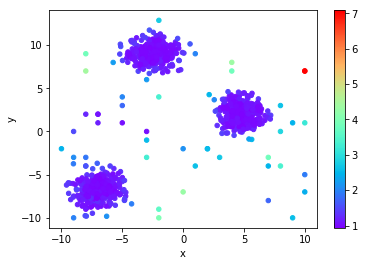

In [7]:

knn_lookup_table = {}
for i in range(X.shape[0]):
    knn_lookup_table[tuple(X[i])] = KNN_table[i]


def reachability_distance(pt1, pt2):
    true_distance = np.linalg.norm(pt1 - pt2) 
    other_knn_distance = np.linalg.norm(pt2 - knn_lookup_table[tuple(pt2)][-1])
    return max([true_distance, other_knn_distance])

local_reach_density_lookup_table = {}
# Calculate each points local reach density and store it in the table
for i in range(X.shape[0]):
    pt = X[i]
    knns = KNN_table[i]
    sum_reachability = 0
    for j in range(len(knns)):
        sum_reachability = sum_reachability + reachability_distance(pt, knns[j])
    avg_reachability = sum_reachability / k
    local_reach_density_lookup_table[tuple(pt)] = (1/avg_reachability)

lofs = []
# Calculate the LoF for each point
for i in range(X.shape[0]):
    pt = X[i]
    knns = KNN_table[i]
    lrd_knns = 0
    for j in range(len(knns)):
        lrd_knns = lrd_knns + local_reach_density_lookup_table[tuple(knns[j])]
    avg_lrd = lrd_knns / k
    lofs.append(avg_lrd/local_reach_density_lookup_table[tuple(pt)])


# Print out our points colored by LoF 
norm = Normalize(vmin=min(lofs), vmax=max(lofs))
cmap = pyplot.cm.rainbow
df.plot(kind='scatter', x='x', y='y', color=cmap(norm(lofs)))
sm = pyplot.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pyplot.colorbar(sm)
pyplot.show()